In [1]:
from __future__ import division
# from models import *
from extended_models import *
from networks import *
from sim_loops import *
import networkx
import pickle
import gzip
import pandas
from scipy.stats import linregress

In [2]:
import matplotlib.pyplot as pyplot
# pyplot.switch_backend('agg')
import seaborn
seaborn.set_style('ticks')

In [3]:
import argparse

parser  = argparse.ArgumentParser()
parser.add_argument("-runID",                         "--runID",                          default="notebook",     type=str)
parser.add_argument("-T",                             "--T",                              default=300,          type=float)
parser.add_argument("-N",                             "--N",                              default=500,        type=int)
parser.add_argument("-INIT_PCT_E",                    "--INIT_PCT_E",                     default=(1/500),    type=float)
parser.add_argument("-INTERVENTION_START_PCT_INFECTED", "--INTERVENTION_START_PCT_INFECTED", default=(1/500),   type=float)
parser.add_argument("-R0_mean",                       "--R0_mean",                        default=2.0,          type=float)
parser.add_argument("-R0_coeffvar",                   "--R0_coeffvar",                    default=0.2,          type=float)
parser.add_argument("-PCT_ASYMPTOMATIC",              "--PCT_ASYMPTOMATIC",               default=0.25,          type=float)
parser.add_argument("-P_GLOBALINTXN",                 "--P_GLOBALINTXN",                  default=0.1,         type=float)
parser.add_argument("-Q_GLOBALINTXN",                 "--Q_GLOBALINTXN",                  default=0.0,          type=float)
parser.add_argument("-O_GLOBALINTXN",                 "--O_GLOBALINTXN",                  default=0.0,         type=float)
parser.add_argument("-PREVALENCE_EXT",                "--PREVALENCE_EXT",                 default=0.00,         type=float)
parser.add_argument("-TESTING_INTERVAL",              "--TESTING_INTERVAL",               default=1,            type=float)
parser.add_argument("-FRAC_TO_TEST_PER_INTERVAL",     "--FRAC_TO_TEST_PER_INTERVAL",      default=(1/7),       type=float)
parser.add_argument("-TEST_FALSENEG_RATE",            "--TEST_FALSENEG_RATE",             default='temporal',   type=str)
parser.add_argument("-TESTING_RANDOM_COMPLIANCE_RATE",          "--TESTING_RANDOM_COMPLIANCE_RATE",          default=1.0, type=float)
parser.add_argument("-TESTING_TRACED_COMPLIANCE_RATE",          "--TESTING_TRACED_COMPLIANCE_RATE",          default=1.0, type=float)
parser.add_argument("-TESTING_SELFSEEK_COMPLIANCE_RATE",        "--TESTING_SELFSEEK_COMPLIANCE_RATE",        default=1.0, type=float)
parser.add_argument("-TESTING_DEGREE_BIAS",           "--TESTING_DEGREE_BIAS",            default=0,            type=float)
parser.add_argument("-MAX_PCT_TESTS_FOR_TRACING",     "--MAX_PCT_TESTS_FOR_TRACING",      default=1.0,          type=float)
parser.add_argument("-TRACING_COMPLIANCE_RATE",       "--TRACING_COMPLIANCE_RATE",        default=1.0,          type=float)
parser.add_argument("-NUM_CONTACTS_TO_TRACE",         "--NUM_CONTACTS_TO_TRACE",          default=None,         type=float)
parser.add_argument("-FRAC_CONTACTS_TO_TRACE",        "--FRAC_CONTACTS_TO_TRACE",         default=1.0,          type=float)
parser.add_argument("-TRACING_INTERVAL_LAG",          "--TRACING_INTERVAL_LAG",           default=2,            type=int)
parser.add_argument("-MAX_PCT_TESTS_FOR_SEEKING",     "--MAX_PCT_TESTS_FOR_SEEKING",      default=1.0,          type=float)
parser.add_argument("-SYMPTOMATIC_SEEKTEST_COMPLIANCE_RATE",    "--SYMPTOMATIC_SEEKTEST_COMPLIANCE_RATE",     default=1.0, type=float)
parser.add_argument("-SYMPTOMATIC_SELFISOLATE_COMPLIANCE_RATE", "--SYMPTOMATIC_SELFISOLATE_COMPLIANCE_RATE",  default=1.0, type=float)
parser.add_argument("-TRACING_SELFISOLATE_COMPLIANCE_RATE",     "--TRACING_SELFISOLATE_COMPLIANCE_RATE",      default=1.0, type=float)
parser.add_argument("-DO_RANDOM_TESTING",             "--DO_RANDOM_TESTING",              default=True,         type=int)
parser.add_argument("-DO_TRACING_TESTING",            "--DO_TRACING_TESTING",             default=True,         type=int)
parser.add_argument("-DO_SEEKING_TESTING",            "--DO_SEEKING_TESTING",             default=True,         type=int)
parser.add_argument("-DO_SYMPTOM_SELFISO",            "--DO_SYMPTOM_SELFISO",             default=True,         type=int)
parser.add_argument("-DO_TRACING_SELFISO",            "--DO_TRACING_SELFISO",             default=False,        type=int)
parser.add_argument("-DO_ISOLATE_POSITIVE_COHORTS",   "--DO_ISOLATE_POSITIVE_COHORTS",    default=False,        type=int)
parser.add_argument("-DO_ISOLATE_POSITIVE_TEAMS",     "--DO_ISOLATE_POSITIVE_TEAMS",      default=True,        type=int)
parser.add_argument("-COHORT_ISOLATION_COMPLIANCE_RATE", "--COHORT_ISOLATION_COMPLIANCE_RATE",                default=1.0, type=float)
parser.add_argument("-TEAM_ISOLATION_COMPLIANCE_RATE", "--TEAM_ISOLATION_COMPLIANCE_RATE",                default=1.0, type=float)
parser.add_argument("-BETA_PAIRWISE_MODE",            "--BETA_PAIRWISE_MODE",             default='mean',       type=str)
parser.add_argument("-ALPHA_PAIRWISE_MODE",           "--ALPHA_PAIRWISE_MODE",            default='mean',       type=str)
parser.add_argument("-TRANSITION_MODE",               "--TRANSITION_MODE",                default='exponential_rates',       type=str)

args, unknown = parser.parse_known_args()

In [4]:
runID           = str(args.runID)

outdir          = "./" 
figdir          = "./" 

T = args.T

N = int(args.N)

INIT_PCT_E   = args.INIT_PCT_E
INIT_EXPOSED = max(int(N*INIT_PCT_E), 0)

INTERVENTION_START_PCT_INFECTED = args.INTERVENTION_START_PCT_INFECTED

R0_mean      = args.R0_mean
R0_coeffvar  = args.R0_coeffvar

PCT_ASYMPTOMATIC = args.PCT_ASYMPTOMATIC

P_GLOBALINTXN = args.P_GLOBALINTXN
Q_GLOBALINTXN = args.Q_GLOBALINTXN
O_GLOBALINTXN = args.O_GLOBALINTXN

PREVALENCE_EXT = args.PREVALENCE_EXT

TESTING_INTERVAL          = args.TESTING_INTERVAL
FRAC_TO_TEST_PER_INTERVAL = args.FRAC_TO_TEST_PER_INTERVAL
TESTS_PER_INTERVAL        = int(N*FRAC_TO_TEST_PER_INTERVAL)
TESTING_DEGREE_BIAS       = args.TESTING_DEGREE_BIAS

TEST_FALSENEG_RATE        = args.TEST_FALSENEG_RATE if args.TEST_FALSENEG_RATE == "temporal" else float(args.TEST_FALSENEG_RATE)

TESTING_RANDOM_COMPLIANCE_RATE   = args.TESTING_RANDOM_COMPLIANCE_RATE
TESTING_TRACED_COMPLIANCE_RATE   = args.TESTING_TRACED_COMPLIANCE_RATE
TESTING_SELFSEEK_COMPLIANCE_RATE = args.TESTING_SELFSEEK_COMPLIANCE_RATE

MAX_PCT_TESTS_FOR_TRACING = args.MAX_PCT_TESTS_FOR_TRACING
TRACING_COMPLIANCE_RATE   = args.TRACING_COMPLIANCE_RATE
NUM_CONTACTS_TO_TRACE     = args.NUM_CONTACTS_TO_TRACE # If None, trace based on fraction of contacts given below
FRAC_CONTACTS_TO_TRACE    = args.FRAC_CONTACTS_TO_TRACE
TRACING_INTERVAL_LAG      = args.TRACING_INTERVAL_LAG

MAX_PCT_TESTS_FOR_SEEKING = args.MAX_PCT_TESTS_FOR_SEEKING

SYMPTOMATIC_SEEKTEST_COMPLIANCE_RATE    = args.SYMPTOMATIC_SEEKTEST_COMPLIANCE_RATE
SYMPTOMATIC_SELFISOLATE_COMPLIANCE_RATE = args.SYMPTOMATIC_SELFISOLATE_COMPLIANCE_RATE
TRACING_SELFISOLATE_COMPLIANCE_RATE     = args.TRACING_SELFISOLATE_COMPLIANCE_RATE

DO_RANDOM_TESTING   = args.DO_RANDOM_TESTING
DO_TRACING_TESTING  = args.DO_TRACING_TESTING
DO_SEEKING_TESTING  = args.DO_SEEKING_TESTING
DO_SYMPTOM_SELFISO  = args.DO_SYMPTOM_SELFISO
DO_TRACING_SELFISO  = args.DO_TRACING_SELFISO

DO_ISOLATE_POSITIVE_COHORTS      = args.DO_ISOLATE_POSITIVE_COHORTS
DO_ISOLATE_POSITIVE_TEAMS        = args.DO_ISOLATE_POSITIVE_TEAMS
COHORT_ISOLATION_COMPLIANCE_RATE = args.COHORT_ISOLATION_COMPLIANCE_RATE
TEAM_ISOLATION_COMPLIANCE_RATE   = args.TEAM_ISOLATION_COMPLIANCE_RATE

BETA_PAIRWISE_MODE  = args.BETA_PAIRWISE_MODE
ALPHA_PAIRWISE_MODE = args.ALPHA_PAIRWISE_MODE
TRANSITION_MODE     = args.TRANSITION_MODE

runStr = ("workplacesim_"+runID)

In [5]:
farz_params={'alpha':    5.0,      # clustering param
             'gamma':    5.0,       # assortativity param
             'beta':     0.7,       # prob within community edges
             'r':        2,         # max num communities node can be part of
             'q':        0.3,       # probability of multi-community membership
             'phi':      10,         # community size similarity (1 gives power law community sizes)
             'b':        0, 
             'epsilon':  1e-6, 
             'directed': False, 
             'weighted': False}

G, cohorts, teams = generate_workplace_contact_network(num_cohorts=5, num_nodes_per_cohort=100, num_teams_per_cohort=10,
                                       mean_intracohort_degree=6, pct_contacts_intercohort=0.2,
                                       farz_params=farz_params)

G_Q = networkx.classes.function.create_empty_copy(G)

baseline graph mean degree       = 11.352
baseline graph median degree     = 10.0
baseline graph CV^2 degree       = 0.44929803467588025
baseline graph assortativity     = 0.12135079967922288
baseline graph clustering coeff  = 0.260508708647


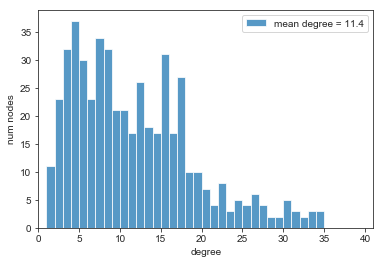

In [6]:
degree      = [d[1] for d in G.degree()]
mean_degree = numpy.mean(degree)
median_degree = numpy.median(degree)
max_degree  = numpy.max(degree)
CV_degree   = numpy.std(degree)/mean_degree
print "baseline graph mean degree       = " + str(mean_degree)
print "baseline graph median degree     = " + str(median_degree)
print "baseline graph CV^2 degree       = " + str(CV_degree**2)

r = networkx.degree_assortativity_coefficient(G)
print "baseline graph assortativity     = " + str(r)

c = networkx.average_clustering(G)
print "baseline graph clustering coeff  = " + str(c)

plot_degree_distn(G)

In [7]:
print cohorts

{'c3': [300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398], 'c2': [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,

In [8]:
print teams

{'c3-t0': [302, 315, 322, 334, 336, 342, 345, 350, 354, 358, 360, 362, 366, 368, 370, 373, 377, 379, 381, 396], 'c3-t7': [303, 305, 306, 319, 332, 346, 372, 385, 390, 392, 394, 399], 'c3-t3': [312, 321, 333, 339, 357, 367, 373, 378, 391], 'c3-t4': [309, 313, 314, 330, 353, 355, 364, 365, 374, 375, 386], 'c1-t2': [100, 110, 111, 112, 113, 114, 118, 120, 121, 130, 138, 149, 152, 160, 176, 179, 180, 190, 191], 'c3-t6': [304, 313, 321, 335, 351, 362, 371, 380], 'c2-t5': [214, 220, 221, 226, 233, 235, 242, 244, 246, 248, 257, 280, 281, 288, 289, 293, 298], 'c2-t4': [208, 214, 231, 256, 262, 265, 287, 291, 292, 293], 'c2-t7': [202, 204, 209, 210, 213, 224, 230, 234, 241, 251, 255, 264, 276, 277, 278, 283, 285, 288, 291, 299], 'c2-t6': [207, 218, 229, 238, 247, 267, 273, 275, 295], 'c2-t1': [204, 205, 206, 218, 243, 245, 247, 254, 271, 279], 'c2-t0': [220, 237, 249, 253, 254, 260, 264, 265, 272, 286], 'c2-t3': [201, 215, 222, 223, 232, 236, 239, 242, 248, 257, 268, 274, 280, 292, 294, 298], '

-------------

Latent period: mean       = 2.978045550150493
Latent period: median     = 2.627296012837549
Latent period: 5  pctile  = 0.7505937525794931
Latent period: 25 pctile  = 1.752109416818795
Latent period: 75 pctile  = 3.82818289237308
Latent period: 95 pctile  = 6.23186277915933
SIGMA mean   = 0.5307868571131767
SIGMA median = 0.38061963232934726
Prodromal period: mean       = 2.240235740419454
Prodromal period: median     = 2.027791070573743
Prodromal period: 5  pctile  = 0.7562534801762061
Prodromal period: 25 pctile  = 1.3850099120174377
Prodromal period: 75 pctile  = 2.894135190392557
Prodromal period: 95 pctile  = 4.444897439171636
LAMDA mean   = 0.6082061461923365
LAMDA median = 0.49314749277712255
Incubation period: mean       = 5.218281290569947
Incubation period: median     = 5.042171584351365
Incubation period: 5  pctile  = 2.2600594945901613
Incubation period: 25 pctile  = 3.662898887170207
Incubation period: 75 pctile  = 6.4634841363384155
Incubation period: 95 pctile  = 8.78917

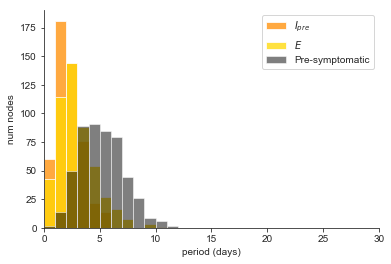

In [9]:
latentPeriods_mean, latentPeriods_coeffvar = 3.0, 0.6
latentPeriods_scale     = latentPeriods_mean*latentPeriods_coeffvar**2    
latentPeriods_shape     = latentPeriods_mean/latentPeriods_scale          
latentPeriods           = numpy.random.gamma(scale=latentPeriods_scale, shape=latentPeriods_shape, size=N)
SIGMA  = 1 / latentPeriods
print("Latent period: mean       = " + str(numpy.mean(numpy.sort(latentPeriods))) )
print("Latent period: median     = "+str(numpy.percentile(numpy.sort(latentPeriods), q=50)) )
print("Latent period: 5  pctile  = "+str(numpy.percentile(numpy.sort(latentPeriods), q=5)) )
print("Latent period: 25 pctile  = "+str(numpy.percentile(numpy.sort(latentPeriods), q=25)) )
print("Latent period: 75 pctile  = "+str(numpy.percentile(numpy.sort(latentPeriods), q=75)) )
print("Latent period: 95 pctile  = "+str(numpy.percentile(numpy.sort(latentPeriods), q=95)) )
print("SIGMA mean   = " +str(numpy.mean(SIGMA)) )
print("SIGMA median = " +str(numpy.median(SIGMA)) )

prodromalPeriod_mean, prodromalPeriod_coeffvar = 2.2, 0.5
prodromalPeriod_scale   = prodromalPeriod_mean*prodromalPeriod_coeffvar**2    # gamma distn theta
prodromalPeriod_shape   = prodromalPeriod_mean/prodromalPeriod_scale          # gamma distn k
prodromalPeriods        = numpy.random.gamma(scale=prodromalPeriod_scale, shape=prodromalPeriod_shape, size=N)
LAMDA = 1 / prodromalPeriods
print("Prodromal period: mean       = "+ str(numpy.mean(numpy.sort(prodromalPeriods))) )
print("Prodromal period: median     = "+str(numpy.percentile(numpy.sort(prodromalPeriods), q=50)) )
print("Prodromal period: 5  pctile  = "+str(numpy.percentile(numpy.sort(prodromalPeriods), q=5)) )
print("Prodromal period: 25 pctile  = "+str(numpy.percentile(numpy.sort(prodromalPeriods), q=25)) )
print("Prodromal period: 75 pctile  = "+str(numpy.percentile(numpy.sort(prodromalPeriods), q=75)) )
print("Prodromal period: 95 pctile  = "+str(numpy.percentile(numpy.sort(prodromalPeriods), q=95)) )
print("LAMDA mean   = " +str(numpy.mean(LAMDA)) )
print("LAMDA median = " +str(numpy.median(LAMDA)) )

incubationPeriods = latentPeriods + prodromalPeriods
print("Incubation period: mean       = " + str(numpy.mean(numpy.sort(incubationPeriods))) )
print("Incubation period: median     = "+str(numpy.percentile(numpy.sort(incubationPeriods), q=50)) )
print("Incubation period: 5  pctile  = "+str(numpy.percentile(numpy.sort(incubationPeriods), q=5)) )
print("Incubation period: 25 pctile  = "+str(numpy.percentile(numpy.sort(incubationPeriods), q=25)) )
print("Incubation period: 75 pctile  = "+str(numpy.percentile(numpy.sort(incubationPeriods), q=75)) )
print("Incubation period: 95 pctile  = "+str(numpy.percentile(numpy.sort(incubationPeriods), q=95)) )
print("Incubation period: 97.5 pctile  = "+str(numpy.percentile(numpy.sort(incubationPeriods), q=97.5)) )

pyplot.hist(prodromalPeriods, bins=range(int(max(prodromalPeriods))), alpha=0.75, color='darkorange', label='$I_{pre}$')
pyplot.hist(latentPeriods, bins=range(int(max(latentPeriods))), alpha=0.75, color='gold', label='$E$')
pyplot.hist(incubationPeriods, bins=range(int(max(incubationPeriods))), alpha=0.5, color='black', label='Pre-symptomatic')
pyplot.xlim(0,30)
pyplot.xlabel('period (days)')
pyplot.ylabel('num nodes')
pyplot.legend(loc='upper right')
seaborn.despine()
pyplot.show()
# pyplot.savefig(figdir+"/incubationPeriods"+runStr+".png")
pyplot.close()

Symptomatic period: mean       = 4.026972768066406
Symptomatic period: median     = 3.8244024947718036
Symptomatic period: 5  pctile  = 1.8490343489911096
Symptomatic period: 25 pctile  = 2.7776374239707464
Symptomatic period: 75 pctile  = 4.907088843192522
Symptomatic period: 95 pctile  = 7.2149022819672926
Symptomatic period: 99.9pctile = 8.486431238992497
Symptomatic period: % in 7-10  = 0.062
GAMMA mean   = 0.2968414745256146
GAMMA median = 0.2614787542900793
Infectious period: mean       = 6.267208508485859
Infectious period: median     = 5.956668604767989
Infectious period: 5  pctile  = 3.416590107933003
Infectious period: 25 pctile  = 4.723912157129556
Infectious period: 75 pctile  = 7.767267395916555
Infectious period: 95 pctile  = 10.006286169505717


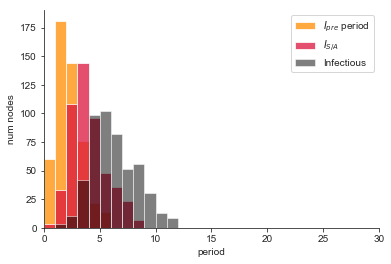

In [10]:
symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
symptomaticPeriod_scale     = symptomaticPeriod_mean*symptomaticPeriod_coeffvar**2    # gamma distn theta
symptomaticPeriod_shape     = symptomaticPeriod_mean/symptomaticPeriod_scale          # gamma distn k
symptomaticPeriods          = numpy.random.gamma(scale=symptomaticPeriod_scale, shape=symptomaticPeriod_shape, size=N)
GAMMA = 1 / symptomaticPeriods
print("Symptomatic period: mean       = " + str(numpy.mean(numpy.sort(symptomaticPeriods))) )
print("Symptomatic period: median     = "+str(numpy.percentile(numpy.sort(symptomaticPeriods), q=50)) )
print("Symptomatic period: 5  pctile  = "+str(numpy.percentile(numpy.sort(symptomaticPeriods), q=5)) )
print("Symptomatic period: 25 pctile  = "+str(numpy.percentile(numpy.sort(symptomaticPeriods), q=25)) )
print("Symptomatic period: 75 pctile  = "+str(numpy.percentile(numpy.sort(symptomaticPeriods), q=75)) )
print("Symptomatic period: 95 pctile  = "+str(numpy.percentile(numpy.sort(symptomaticPeriods), q=95)) )
print("Symptomatic period: 99.9pctile = "+str(numpy.percentile(numpy.sort(symptomaticPeriods), q=99)) )
print("Symptomatic period: % in 7-10  = "+str(len(symptomaticPeriods[ numpy.where( (symptomaticPeriods >= 7)&(symptomaticPeriods <= 10) ) ])/len(symptomaticPeriods)) )
print("GAMMA mean   = " +str(numpy.mean(GAMMA)) )
print("GAMMA median = " +str(numpy.median(GAMMA)) )

infectiousPeriods = prodromalPeriods + symptomaticPeriods
print("Infectious period: mean       = " + str(numpy.mean(numpy.sort(infectiousPeriods))) )
print("Infectious period: median     = "+str(numpy.percentile(numpy.sort(infectiousPeriods), q=50)) )
print("Infectious period: 5  pctile  = "+str(numpy.percentile(numpy.sort(infectiousPeriods), q=5)) )
print("Infectious period: 25 pctile  = "+str(numpy.percentile(numpy.sort(infectiousPeriods), q=25)) )
print("Infectious period: 75 pctile  = "+str(numpy.percentile(numpy.sort(infectiousPeriods), q=75)) )
print("Infectious period: 95 pctile  = "+str(numpy.percentile(numpy.sort(infectiousPeriods), q=95)) )

pyplot.hist(prodromalPeriods, bins=range(int(max(prodromalPeriods))), alpha=0.75, color='darkorange', label='$I_{pre}$ period')
pyplot.hist(symptomaticPeriods, bins=range(int(max(symptomaticPeriods))), alpha=0.75, color='crimson', label='$I_{S/A}$')
pyplot.hist(infectiousPeriods, bins=range(int(max(infectiousPeriods))), alpha=0.5, color='black', label='Infectious')
pyplot.xlim(0,30)
pyplot.xlabel('period')
pyplot.ylabel('num nodes')
pyplot.legend(loc='upper right')
seaborn.despine()
pyplot.show()
# pyplot.savefig(figdir+"/infectiousPeriods"+runStr+".png")
pyplot.close()

Onset-to-Hospitalization period: mean       = 11.155125404842172
Onset-to-Hospitalization period: median     = 10.467531095023116
Onset-to-Hospitalization period: 5  pctile  = 4.130086574505802
Onset-to-Hospitalization period: 25 pctile  = 7.7571301641880925
Onset-to-Hospitalization period: 75 pctile  = 13.855423466561197
Onset-to-Hospitalization period: 95 pctile  = 19.913099698522554
ETA mean   = 0.1150903017524825
ETA median = 0.0955335242953266
Hospitalization-to-Discharge period: mean       = 11.443450679514445
Hospitalization-to-Discharge period: median     = 10.482302925509236
Hospitalization-to-Discharge period: 5  pctile  = 4.482576150299678
Hospitalization-to-Discharge period: 25 pctile  = 7.39899975091624
Hospitalization-to-Discharge period: 75 pctile  = 14.385334177555599
Hospitalization-to-Discharge period: 95 pctile  = 21.456231592016735
GAMMA_H mean   = 0.11121542044001657
GAMMA_H median = 0.09539893523167128
Onset-to-Discharge period: mean       = 22.598576084356615
Ons

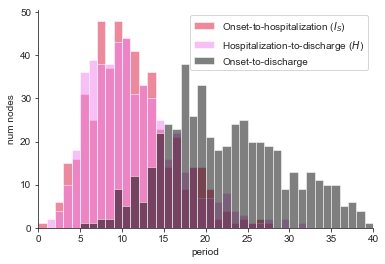

In [11]:
onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
onsetToHospitalizationPeriod_scale  = onsetToHospitalizationPeriod_mean*onsetToHospitalizationPeriod_coeffvar**2    # gamma distn theta
onsetToHospitalizationPeriod_shape  = onsetToHospitalizationPeriod_mean/onsetToHospitalizationPeriod_scale          # gamma distn k
onsetToHospitalizationPeriods           = numpy.random.gamma(scale=onsetToHospitalizationPeriod_scale, shape=onsetToHospitalizationPeriod_shape, size=N)
ETA = 1 / onsetToHospitalizationPeriods
print("Onset-to-Hospitalization period: mean       = " + str(numpy.mean(numpy.sort(onsetToHospitalizationPeriods))) )
print("Onset-to-Hospitalization period: median     = "+str(numpy.percentile(numpy.sort(onsetToHospitalizationPeriods), q=50)) )
print("Onset-to-Hospitalization period: 5  pctile  = "+str(numpy.percentile(numpy.sort(onsetToHospitalizationPeriods), q=5)) )
print("Onset-to-Hospitalization period: 25 pctile  = "+str(numpy.percentile(numpy.sort(onsetToHospitalizationPeriods), q=25)) )
print("Onset-to-Hospitalization period: 75 pctile  = "+str(numpy.percentile(numpy.sort(onsetToHospitalizationPeriods), q=75)) )
print("Onset-to-Hospitalization period: 95 pctile  = "+str(numpy.percentile(numpy.sort(onsetToHospitalizationPeriods), q=95)) )
print("ETA mean   = " +str(numpy.mean(ETA)) )
print("ETA median = " +str(numpy.median(ETA)) )

hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 11.0, 0.45
hospitalizationToDischargePeriod_scale  = hospitalizationToDischargePeriod_mean*hospitalizationToDischargePeriod_coeffvar**2    # gamma distn theta
hospitalizationToDischargePeriod_shape  = hospitalizationToDischargePeriod_mean/hospitalizationToDischargePeriod_scale          # gamma distn k
hospitalizationToDischargePeriods       = numpy.random.gamma(scale=hospitalizationToDischargePeriod_scale, shape=hospitalizationToDischargePeriod_shape, size=N)
GAMMA_H = 1 / hospitalizationToDischargePeriods
print("Hospitalization-to-Discharge period: mean       = " + str(numpy.mean(numpy.sort(hospitalizationToDischargePeriods))) )
print("Hospitalization-to-Discharge period: median     = "+str(numpy.percentile(numpy.sort(hospitalizationToDischargePeriods), q=50)) )
print("Hospitalization-to-Discharge period: 5  pctile  = "+str(numpy.percentile(numpy.sort(hospitalizationToDischargePeriods), q=5)) )
print("Hospitalization-to-Discharge period: 25 pctile  = "+str(numpy.percentile(numpy.sort(hospitalizationToDischargePeriods), q=25)) )
print("Hospitalization-to-Discharge period: 75 pctile  = "+str(numpy.percentile(numpy.sort(hospitalizationToDischargePeriods), q=75)) )
print("Hospitalization-to-Discharge period: 95 pctile  = "+str(numpy.percentile(numpy.sort(hospitalizationToDischargePeriods), q=95)) )
print("GAMMA_H mean   = " +str(numpy.mean(GAMMA_H)) )
print("GAMMA_H median = " +str(numpy.median(GAMMA_H)) )

onsetToDischargePeriods = onsetToHospitalizationPeriods + hospitalizationToDischargePeriods
print("Onset-to-Discharge period: mean       = " + str(numpy.mean(numpy.sort(onsetToDischargePeriods))) )
print("Onset-to-Discharge period: median     = "+str(numpy.percentile(numpy.sort(onsetToDischargePeriods), q=50)) )
print("Onset-to-Discharge period: 5  pctile  = "+str(numpy.percentile(numpy.sort(onsetToDischargePeriods), q=5)) )
print("Onset-to-Discharge period: 25 pctile  = "+str(numpy.percentile(numpy.sort(onsetToDischargePeriods), q=25)) )
print("Onset-to-Discharge period: 75 pctile  = "+str(numpy.percentile(numpy.sort(onsetToDischargePeriods), q=75)) )
print("Onset-to-Discharge period: 95 pctile  = "+str(numpy.percentile(numpy.sort(onsetToDischargePeriods), q=95)) )

pyplot.hist(onsetToHospitalizationPeriods, bins=range(int(max(onsetToHospitalizationPeriods))), alpha=0.5, color='crimson', label='Onset-to-hospitalization ($I_S$)')
pyplot.hist(hospitalizationToDischargePeriods, bins=range(int(max(hospitalizationToDischargePeriods))), alpha=0.5, color='violet', label='Hospitalization-to-discharge ($H$)')
pyplot.hist(onsetToDischargePeriods, bins=range(int(max(onsetToDischargePeriods))), alpha=0.5, color='black', label='Onset-to-discharge')
pyplot.xlim(0,40)
pyplot.xlabel('period')
pyplot.ylabel('num nodes')
pyplot.legend(loc='upper right')
seaborn.despine()
pyplot.show()
# pyplot.savefig(figdir+"/onsetToDischargePeriods"+runStr+".png")
pyplot.close()

Hospitalization-to-Death period: mean       = 6.9379343949065735
Hospitalization-to-Death period: median     = 6.650122950856161
Hospitalization-to-Death period: 5  pctile  = 2.711678218323395
Hospitalization-to-Death period: 25 pctile  = 4.83000909755273
Hospitalization-to-Death period: 75 pctile  = 8.803504163624645
Hospitalization-to-Death period: 95 pctile  = 12.135583548800787
0.286
MU_H mean   = 0.17929912576289353
MU_H median = 0.15037324044039652
Onset-to-Death period: mean       = 18.093059799748747
Onset-to-Death period: median     = 17.545871463935065
Onset-to-Death period: 5  pctile  = 9.345233426856014
Onset-to-Death period: 25 pctile  = 14.144384104816321
Onset-to-Death period: 75 pctile  = 21.874712540269762
Onset-to-Death period: 95 pctile  = 27.97222956942877


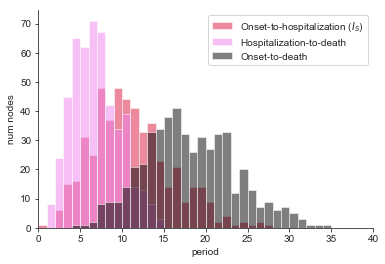

In [12]:
hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 7.0, 0.45
hospitalizationToDeathPeriod_scale  = hospitalizationToDeathPeriod_mean*hospitalizationToDeathPeriod_coeffvar**2    # gamma distn theta
hospitalizationToDeathPeriod_shape  = hospitalizationToDeathPeriod_mean/hospitalizationToDeathPeriod_scale          # gamma distn k
hospitalizationToDeathPeriods       = numpy.random.gamma(scale=hospitalizationToDeathPeriod_scale, shape=hospitalizationToDeathPeriod_shape, size=N)
MU_H = 1 / hospitalizationToDeathPeriods
print("Hospitalization-to-Death period: mean       = " + str(numpy.mean(numpy.sort(hospitalizationToDeathPeriods))) )
print("Hospitalization-to-Death period: median     = "+str(numpy.percentile(numpy.sort(hospitalizationToDeathPeriods), q=50)) )
print("Hospitalization-to-Death period: 5  pctile  = "+str(numpy.percentile(numpy.sort(hospitalizationToDeathPeriods), q=5)) )
print("Hospitalization-to-Death period: 25 pctile  = "+str(numpy.percentile(numpy.sort(hospitalizationToDeathPeriods), q=25)) )
print("Hospitalization-to-Death period: 75 pctile  = "+str(numpy.percentile(numpy.sort(hospitalizationToDeathPeriods), q=75)) )
print("Hospitalization-to-Death period: 95 pctile  = "+str(numpy.percentile(numpy.sort(hospitalizationToDeathPeriods), q=95)) )
print(len(hospitalizationToDeathPeriods[ numpy.where( (hospitalizationToDeathPeriods >= 7)&(hospitalizationToDeathPeriods <= 10) ) ])/len(hospitalizationToDeathPeriods) )
print("MU_H mean   = " +str(numpy.mean(MU_H)) )
print("MU_H median = " +str(numpy.median(MU_H)) )

onsetToDeathPeriods = onsetToHospitalizationPeriods + hospitalizationToDeathPeriods
print("Onset-to-Death period: mean       = " + str(numpy.mean(numpy.sort(onsetToDeathPeriods))) )
print("Onset-to-Death period: median     = "+str(numpy.percentile(numpy.sort(onsetToDeathPeriods), q=50)) )
print("Onset-to-Death period: 5  pctile  = "+str(numpy.percentile(numpy.sort(onsetToDeathPeriods), q=5)) )
print("Onset-to-Death period: 25 pctile  = "+str(numpy.percentile(numpy.sort(onsetToDeathPeriods), q=25)) )
print("Onset-to-Death period: 75 pctile  = "+str(numpy.percentile(numpy.sort(onsetToDeathPeriods), q=75)) )
print("Onset-to-Death period: 95 pctile  = "+str(numpy.percentile(numpy.sort(onsetToDeathPeriods), q=95)) )

pyplot.hist(onsetToHospitalizationPeriods, bins=range(int(max(onsetToHospitalizationPeriods))), alpha=0.5, color='crimson', label='Onset-to-hospitalization ($I_S$)')
pyplot.hist(hospitalizationToDeathPeriods, bins=range(int(max(hospitalizationToDeathPeriods))), alpha=0.5, color='violet', label='Hospitalization-to-death')
pyplot.hist(onsetToDeathPeriods, bins=range(int(max(onsetToDeathPeriods))), alpha=0.5, color='black', label='Onset-to-death')
pyplot.xlim(0,40)
pyplot.xlabel('period')
pyplot.ylabel('num nodes')
pyplot.legend(loc='upper right')
seaborn.despine()
pyplot.show()
# pyplot.savefig(figdir+"/onsetToDeathPeriods"+runStr+".png")
pyplot.close()

R0: mean       = 1.983664933758877
R0: median     = 1.9393102969824347
R0: 5  pctile  = 1.4007586832617986
R0: 25 pctile  = 1.7012718174973465
R0: 50 pctile  = 1.9393102969824347
R0: 75 pctile  = 2.227459442045845
R0: 95 pctile  = 2.715179804403259
R0: < mean: 56.6%
R0: > 1:    100.0%
R0: > 2:    43.4%
R0: > 3:    1.6%
R0: > 4:    0.0%
R0: 80 pctile:   2.3071333183452625
R0: Top 20 does: 0.26118971054889334


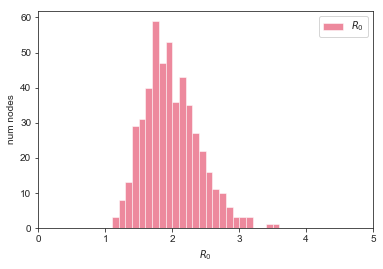

In [13]:
R0_mean, R0_coeffvar = R0_mean, R0_coeffvar
R0_scale      = R0_mean*R0_coeffvar**2    # gamma distn theta
R0_shape      = R0_mean/R0_scale          # gamma distn k
R0 = numpy.random.gamma(scale=R0_scale, shape=R0_shape, size=N)

print("R0: mean       = " + str(numpy.mean(numpy.sort(R0))) )
print("R0: median     = " + str(numpy.median(numpy.sort(R0))) )
print("R0: 5  pctile  = "+str(numpy.percentile(numpy.sort(R0), q=5)) )
print("R0: 25 pctile  = "+str(numpy.percentile(numpy.sort(R0), q=25)) )
print("R0: 50 pctile  = "+str(numpy.percentile(numpy.sort(R0), q=50)) )
print("R0: 75 pctile  = "+str(numpy.percentile(numpy.sort(R0), q=75)) )
print("R0: 95 pctile  = "+str(numpy.percentile(numpy.sort(R0), q=95)) )
print "R0: < mean: "+str(numpy.count_nonzero(R0[R0 < R0_mean])/N*100)+"%"
print "R0: > 1:    "+str(numpy.count_nonzero(R0[R0 > 1])/N*100)+"%"
print "R0: > 2:    "+str(numpy.count_nonzero(R0[R0 > 2])/N*100)+"%"
print "R0: > 3:    "+str(numpy.count_nonzero(R0[R0 > 3])/N*100)+"%"
print "R0: > 4:    "+str(numpy.count_nonzero(R0[R0 > 4])/N*100)+"%"
print "R0: 80 pctile:   "+str(numpy.percentile(numpy.sort(R0), q=80))
print "R0: Top 20 does: "+str( numpy.sum(R0[R0 > numpy.percentile(numpy.sort(R0), q=80)])/numpy.sum(R0) )

pyplot.hist(R0, bins=numpy.arange(0, int(max(R0+1)), step=0.1), alpha=0.5, color='crimson', label='$R_0$')
pyplot.xlim(0,5)
pyplot.xlabel('$R_0$')
pyplot.ylabel('num nodes')
pyplot.legend(loc='upper right')
pyplot.show()
# pyplot.savefig(figdir+"/R0distn"+runStr+".png")
pyplot.close()

In [14]:
BETA     = 1/infectiousPeriods * R0
print("mean beta = "+str(numpy.mean(BETA)) )
print("beta: mean       = " + str(numpy.mean(numpy.sort(BETA))) )
print("beta: 5  pctile  = "+str(numpy.percentile(numpy.sort(BETA), q=5)) )
print("beta: 25 pctile  = "+str(numpy.percentile(numpy.sort(BETA), q=25)) )
print("beta: 50 pctile  = "+str(numpy.percentile(numpy.sort(BETA), q=50)) )
print("beta: 75 pctile  = "+str(numpy.percentile(numpy.sort(BETA), q=75)) )
print("beta: 95 pctile  = "+str(numpy.percentile(numpy.sort(BETA), q=95)) )

BETA_Q = BETA * (0.3/R0_mean) 
print("mean beta_D = "+str(numpy.mean(BETA_Q)) )
print("beta_Q: mean       = " + str(numpy.mean(numpy.sort(BETA_Q))) )
print("beta_Q: 5  pctile  = "+str(numpy.percentile(numpy.sort(BETA_Q), q=5)) )
print("beta_Q: 25 pctile  = "+str(numpy.percentile(numpy.sort(BETA_Q), q=25)) )
print("beta_Q: 50 pctile  = "+str(numpy.percentile(numpy.sort(BETA_Q), q=50)) )
print("beta_Q: 75 pctile  = "+str(numpy.percentile(numpy.sort(BETA_Q), q=75)) )
print("beta_Q: 95 pctile  = "+str(numpy.percentile(numpy.sort(BETA_Q), q=95)) )

mean beta = 0.35622871699579994
beta: mean       = 0.35622871699580005
beta: 5  pctile  = 0.173372127789537
beta: 25 pctile  = 0.24817876041017947
beta: 50 pctile  = 0.3283468913976917
beta: 75 pctile  = 0.43485838005876126
beta: 95 pctile  = 0.601926311214441
mean beta_D = 0.05343430754936999
beta_Q: mean       = 0.053434307549369994
beta_Q: 5  pctile  = 0.026005819168430547
beta_Q: 25 pctile  = 0.03722681406152692
beta_Q: 50 pctile  = 0.04925203370965375
beta_Q: 75 pctile  = 0.06522875700881417
beta_Q: 95 pctile  = 0.09028894668216614


In [15]:
# Source: Verity et al.
ageGroup_pctHospitalized = {'0-9':      0.0000,
                            '10-19':    0.0004,
                            '20-29':    0.0104,
                            '30-39':    0.0343,
                            '40-49':    0.0425,
                            '50-59':    0.0816,
                            '60-69':    0.118,
                            '70-79':    0.166,
                            '80+':      0.184 }
# PCT_HOSPITALIZED = [ageGroup_pctHospitalized[ageGroup] for ageGroup in individual_ageGroups]
PCT_HOSPITALIZED = numpy.mean([ageGroup_pctHospitalized[age] for age in ['20-29', '30-39', '40-49', '50-59']])
print PCT_HOSPITALIZED

0.0422


In [16]:
# Source: Verity et al.
ageGroup_hospitalFatalityRate = {'0-9':     0.0000,
                                 '10-19':   0.3627,
                                 '20-29':   0.0577,
                                 '30-39':   0.0426,
                                 '40-49':   0.0694,
                                 '50-59':   0.1532,
                                 '60-69':   0.3381,
                                 '70-79':   0.5187,
                                 '80+':     0.7283 }
# PCT_FATALITY = [ageGroup_hospitalFatalityRate[ageGroup] for ageGroup in individual_ageGroups]
PCT_FATALITY = numpy.mean([ageGroup_hospitalFatalityRate[age] for age in ['20-29', '30-39', '40-49', '50-59']])
print PCT_FATALITY

0.080725


In [17]:
TESTING_RANDOM_COMPLIANCE   = (numpy.random.rand(N) < TESTING_RANDOM_COMPLIANCE_RATE)
TESTING_TRACED_COMPLIANCE   = (numpy.random.rand(N) < TESTING_TRACED_COMPLIANCE_RATE)
TESTING_SELFSEEK_COMPLIANCE = (numpy.random.rand(N) < TESTING_SELFSEEK_COMPLIANCE_RATE)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

TRACING_COMPLIANCE = (numpy.random.rand(N) < TRACING_COMPLIANCE_RATE)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

SYMPTOMATIC_SEEKTEST_COMPLIANCE = (numpy.random.rand(N) < SYMPTOMATIC_SEEKTEST_COMPLIANCE_RATE)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

SYMPTOMATIC_SELFISOLATE_COMPLIANCE = (numpy.random.rand(N) < SYMPTOMATIC_SELFISOLATE_COMPLIANCE_RATE)
TRACING_SELFISOLATE_COMPLIANCE     = (numpy.random.rand(N) < TRACING_SELFISOLATE_COMPLIANCE_RATE)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

COHORT_ISOLATION_COMPLIANCE = (numpy.random.rand(N) < COHORT_ISOLATION_COMPLIANCE_RATE)
TEAM_ISOLATION_COMPLIANCE   = (numpy.random.rand(N) < TEAM_ISOLATION_COMPLIANCE_RATE)

--------

# SCENARIO

In [18]:
model = ExtSEIRSNetworkModel(G=G, p=P_GLOBALINTXN,
                                        beta=BETA, sigma=SIGMA, lamda=LAMDA, gamma=GAMMA, 
                                        gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H, 
                                        a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                                        beta_pairwise_mode=BETA_PAIRWISE_MODE, alpha_pairwise_mode=ALPHA_PAIRWISE_MODE,
                                        G_Q=G_Q, q=0, beta_Q=BETA_Q, isolation_time=14,
                                        o=O_GLOBALINTXN, prevalence_ext=PREVALENCE_EXT,
                                        initE=INIT_EXPOSED, transition_mode=TRANSITION_MODE)

extended_models.py:484: RuntimeWarning: divide by zero encountered in log
  self.alpha_Q             = numpy.log(self.degree_Q)/numpy.log(numpy.mean(self.degree_Q)) if self.parameters['alpha_Q'] is None else numpy.array(self.parameters['alpha_Q']) if isinstance(self.parameters['alpha_Q'], (list, numpy.ndarray)) else numpy.full(fill_value=self.parameters['alpha_Q'], shape=(self.numNodes,1))
extended_models.py:484: RuntimeWarning: invalid value encountered in true_divide
  self.alpha_Q             = numpy.log(self.degree_Q)/numpy.log(numpy.mean(self.degree_Q)) if self.parameters['alpha_Q'] is None else numpy.array(self.parameters['alpha_Q']) if isinstance(self.parameters['alpha_Q'], (list, numpy.ndarray)) else numpy.full(fill_value=self.parameters['alpha_Q'], shape=(self.numNodes,1))


In [19]:
interventionInterval = run_workplace_testing_sim(
                              model=model, T=T, intervention_start_pct_infected=INTERVENTION_START_PCT_INFECTED,
                              testing_interval=TESTING_INTERVAL, tests_per_interval=TESTS_PER_INTERVAL, test_falseneg_rate=TEST_FALSENEG_RATE,
                              do_random_testing=DO_RANDOM_TESTING, testing_random_compliance=TESTING_RANDOM_COMPLIANCE, testing_degree_bias=TESTING_DEGREE_BIAS,
                              do_tracing_testing=DO_TRACING_TESTING, tracing_compliance=TRACING_COMPLIANCE, testing_traced_compliance=TESTING_TRACED_COMPLIANCE, max_pct_tests_for_tracing=MAX_PCT_TESTS_FOR_TRACING, num_contacts_to_trace=NUM_CONTACTS_TO_TRACE, frac_contacts_to_trace=FRAC_CONTACTS_TO_TRACE, tracing_interval_lag=TRACING_INTERVAL_LAG,
                              do_seeking_testing=DO_SEEKING_TESTING, symptomatic_seektest_compliance=SYMPTOMATIC_SEEKTEST_COMPLIANCE, testing_selfseek_compliance=TESTING_SELFSEEK_COMPLIANCE, max_pct_tests_for_seeking=MAX_PCT_TESTS_FOR_SEEKING,
                              do_symptom_selfiso=DO_SYMPTOM_SELFISO, symptomatic_selfiso_compliance=SYMPTOMATIC_SELFISOLATE_COMPLIANCE, 
                              do_tracing_selfiso=DO_TRACING_SELFISO, tracing_selfiso_compliance=TRACING_SELFISOLATE_COMPLIANCE,
                              isolate_positive_cohorts=DO_ISOLATE_POSITIVE_COHORTS, cohort_isolation_compliance=COHORT_ISOLATION_COMPLIANCE, cohorts=cohorts,
                              isolate_positive_teams=DO_ISOLATE_POSITIVE_TEAMS, team_isolation_compliance=TEAM_ISOLATION_COMPLIANCE, teams=teams,
                              introduction_interval=1, average_introductions_per_interval=0/30
                            )

[TESTING @ t = 3.05 (0.20% infected)]
	1 current undetected infections
	0 self-isolated due to symptoms (0 as housemates of symptomatic)
	0 isolated due to positive test (0 as teammates of positive, 0 as cohortmates of positive)
	0	tested self-seek	[+ 0 positive (0.00 %) +]
	0	tested as traces	[+ 0 positive (0.00 %) +]
	71	tested randomly		[+ 0 positive (0.00 %) +]
	71	tested TOTAL	[+ 0 positive (0.00 %) +]
[TESTING @ t = 5.14 (0.40% infected)]
	2 current undetected infections
	1 self-isolated due to symptoms (0 as housemates of symptomatic)
	2 isolated due to positive test (36 as teammates of positive, 0 as cohortmates of positive)
	1	tested self-seek	[+ 1 positive (100.00 %) +]
	0	tested as traces	[+ 0 positive (0.00 %) +]
	70	tested randomly		[+ 1 positive (1.43 %) +]
	71	tested TOTAL	[+ 2 positive (2.82 %) +]
[TESTING @ t = 6.47 (0.60% infected)]
	2 current undetected infections
	0 self-isolated due to symptoms (0 as housemates of symptomatic)
	0 isolated due to positive test (0 as

In [20]:
print("total percent infected: %0.2f%%" % ((model.total_num_infected()[-1]+model.total_num_recovered()[-1])/N * 100) )
print("total percent fatality: %0.2f%%" % (model.numF[-1]/N * 100) )
print("peak  pct hospitalized: %0.2f%%" % (numpy.max(model.numH)/N * 100) )

total percent infected: 0.60%
total percent fatality: 0.00%
peak  pct hospitalized: 0.20%


--------

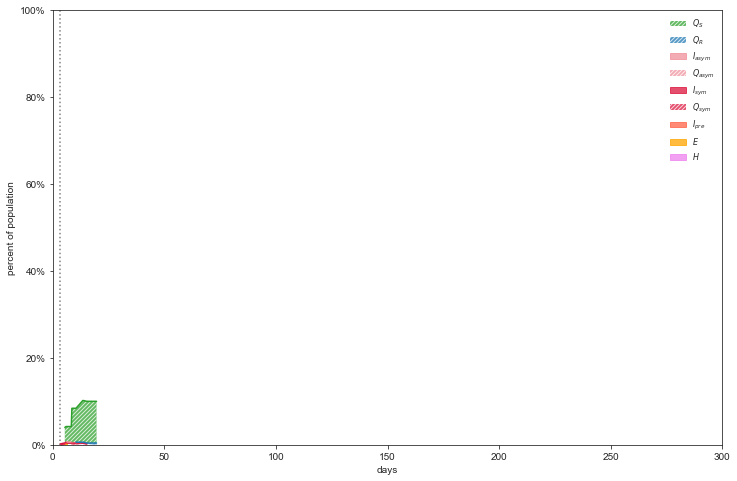

In [21]:
fig, ax = model.figure_infections(combine_Q_infected=False, show=False, use_seaborn=False,
                                    plot_Q_R='stacked', #plot_R='stacked', 
                                    plot_Q_S='stacked', #plot_S='stacked', 
                                    vlines=[interventionInterval[0]],
                                    ylim=1, xlim=300
                                 )

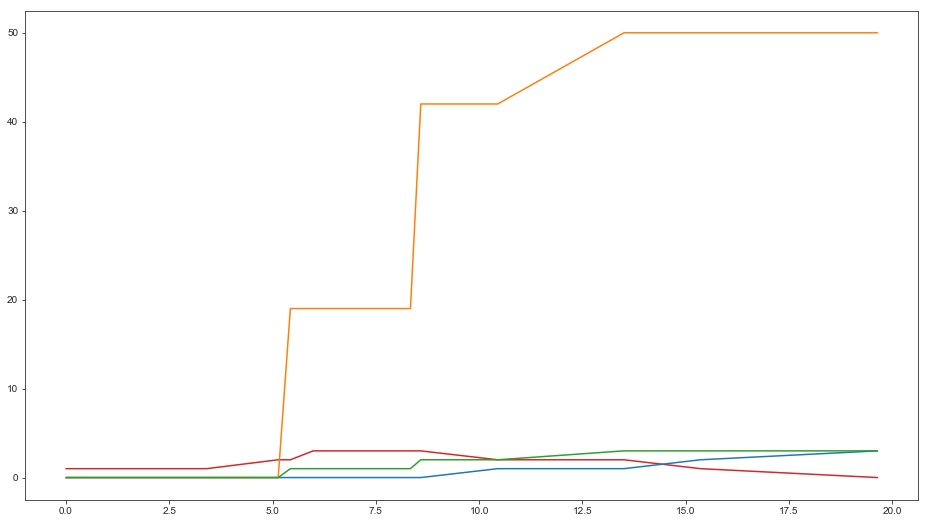

In [22]:
fig, ax = pyplot.subplots(figsize=(16,9))
ax.plot(model.tseries, model.total_num_infected(), color='tab:red')
ax.plot(model.tseries, model.total_num_recovered(), color='tab:blue')
ax.plot(model.tseries, model.total_num_isolated(), color='tab:orange')
ax.plot(model.tseries, model.total_num_positive(), color='tab:green')